# Projet HDDL — Multi-tâche : Segmentation + Classification (Oxford-IIIT Pet)

#### Objectif: modifier l'architecture de U-Net pour pouvoir faire 2 tâches:
- **Segmentation** (3 classes : animal / fond / bordure)
- **Classification** sur la même image

On teste **deux variantes** de classification :
1. **Binaire (2 classes)** : Chat vs Chien
2. **Fine (37 classes)** : Prédire la race exacte


## 0) Imports et configuration
On charge les librairies et on fixe les paramètres.

In [1]:

import os
import random
import json
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

class CFG:
    ROOT_DIR: str = "/home/el-morady/Téléchargements/HDDL_fv" 
    IMG_SIZE: Tuple[int,int] = (256, 256)
    BATCH_SIZE = 16
    NUM_WORKERS = 0
    PIN_MEMORY = False
    NUM_SEG_CLASSES = 3
    IGNORE_INDEX = None
    LR: float = 1e-4
    EPOCHS: int = 10
    VAL_RATIO: float = 0.10
    LAMBDA_CLS: float = 0.5

cfg = CFG()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("ROOT_DIR:", cfg.ROOT_DIR)


Device: cuda
ROOT_DIR: /home/el-morady/Téléchargements/HDDL_fv


## 1) Utilitaires : race, chat/chien, mapping 37 races

- **Classification Binaire** : Majuscule → chat, minuscule → chien (règle de notre dataset)
- **Classification Fine** : mapping `race -> id` (0..36)


In [3]:

def extract_breed(filename: str) -> str:
    return "_".join(filename.split("_")[:-1])

def catdog_label_from_filename(filename: str) -> int:
    # 0 = chat, 1 = chien
    return 0 if filename[0].isupper() else 1

def build_breed_mapping(root_dir: str):
    # On lit list.txt + test.txt pour être sûr de couvrir toutes les races
    breeds = set()
    for listname in ["list.txt", "test.txt"]:
        path = os.path.join(root_dir, "annotations", listname)
        with open(path, "r") as f:
            for line in f:
                if line.startswith("#") or not line.strip():
                    continue
                name = line.split()[0] 
                breeds.add(extract_breed(name))
    breeds = sorted(list(breeds))
    breed_to_id = {b:i for i,b in enumerate(breeds)}
    id_to_breed = {i:b for b,i in breed_to_id.items()}
    return breeds, breed_to_id, id_to_breed

breeds, breed_to_id, id_to_breed = build_breed_mapping(cfg.ROOT_DIR)
print("Nombre de races (attendu 37) =", len(breeds))


Nombre de races (attendu 37) = 37


## 2) Dataset segmentation de base

In [4]:
class OxfordSegmentationDataset(Dataset):
    def __init__(self, root_dir, split="trainval", target_size=(256, 256)):
        self.root_dir = root_dir
        self.target_size = target_size
         
        self.images_dir = os.path.join(self.root_dir, 'images')   
        self.masks_dir  = os.path.join(self.root_dir, 'annotations', 'trimaps')

        list_filename   = "list.txt" if split == "trainval" else "test.txt"
        list_file_path  = os.path.join(self.root_dir, 'annotations', list_filename)

        self.data_list = []
        
        with open(list_file_path, 'r') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    parts = line.split()
                    filename_no_ext = parts[0]
                    self.data_list.append(filename_no_ext)

        print(f"Dataset {split} chargé : {len(self.data_list)} images.")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        filename = self.data_list[idx]

        img_path  = os.path.join(self.images_dir, filename + ".jpg")
        mask_path = os.path.join(self.masks_dir,  filename + ".png")

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path) 

        image = image.resize(self.target_size, Image.BILINEAR)
        mask  = mask.resize(self.target_size, Image.NEAREST)

        img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        image_tensor = img_transform(image)
        mask_np = np.array(mask, dtype=np.int64)  
        mask_np = mask_np - 1   
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.long)

        return image_tensor, mask_tensor, filename

## 3) Dataset multi-tâche (segmentation + classification)
On construit un dataset multi-tâche à partir du dataset segmentation.

Deux modes :
- `cls_mode='binary'` : label 0/1 (chat/chien)
- `cls_mode='breed'`  : label 0..36 (race)


In [5]:

class OxfordMultiTaskDataset(OxfordSegmentationDataset):
    def __init__(self, root_dir: str, split: str = "trainval", target_size=(256,256),
                 cls_mode: str = "binary"):
        super().__init__(root_dir, split=split, target_size=target_size)
        assert cls_mode in ["binary", "breed"]
        self.cls_mode = cls_mode
        self.breeds, self.breed_to_id, self.id_to_breed = build_breed_mapping(root_dir)

    def __getitem__(self, idx: int):
        image, mask, filename = super().__getitem__(idx)

        if self.cls_mode == "binary":
            cls_label = catdog_label_from_filename(filename)  # 0/1
        else:
            cls_label = self.breed_to_id[extract_breed(filename)]  # 0..36

        return image, mask.long(), torch.tensor(cls_label, dtype=torch.long), filename


## 4) Split train/val/test (pour multi-tâche)
On utilise :
- `trainval` → split en train/val
- `test`     → test

On crée des loaders pour `binary` et pour `breed`.

In [6]:
trainval_dataset = OxfordMultiTaskDataset(cfg.ROOT_DIR, split="trainval", target_size=(256,256), cls_mode = "binary")
test_dataset     = OxfordMultiTaskDataset(cfg.ROOT_DIR, split="test",     target_size=(256,256), cls_mode = "binary")

val_ratio = 0.10
n_total = len(trainval_dataset)
n_val   = int(val_ratio * n_total)
n_train = n_total - n_val

g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val], generator=g)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

Dataset trainval chargé : 7349 images.
Dataset test chargé : 3669 images.


## 5) U-Net + tête de classification (encodeur partagé)
On ajoute une tête `AvgPool + Linear` au bottleneck.
Le modèle retourne : `(seg_logits, cls_logits)`.

In [7]:

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=None):
        super().__init__()
        if mid_ch is None:
            mid_ch = out_ch
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch, mid_ch=in_ch//2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNetMultiTask(nn.Module):
    def __init__(self, n_channels=3, n_seg_classes=3, n_cls_classes=2, bilinear=False):
        super().__init__()
        self.inc   = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear=bilinear)
        self.up2 = Up(512, 256 // factor, bilinear=bilinear)
        self.up3 = Up(256, 128 // factor, bilinear=bilinear)
        self.up4 = Up(128, 64, bilinear=bilinear)
        self.outc = OutConv(64, n_seg_classes)

        bottleneck_channels = 1024 // factor
        self.cls_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_head = nn.Linear(bottleneck_channels, n_cls_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        z = self.cls_pool(x5).squeeze(-1).squeeze(-1)
        cls_logits = self.cls_head(z)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        seg_logits = self.outc(x)

        return seg_logits, cls_logits


## 6) Métriques : segmentation (Dice/IoU) et classification (Accuracy)

In [8]:
def calculate_metrics_multiclass(pred_mask, true_mask, num_classes = 3, ignore_index = None, eps = 1e-6):
    dice_pc = [0.0] * num_classes
    iou_pc  = [0.0] * num_classes

    used = []
    for c in range(num_classes):
        if ignore_index is not None and c == ignore_index:
            continue
        pred_c   = (pred_mask == c).float()
        target_c = (true_mask == c).float()

        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum() - inter

        dice = (2*inter + eps) / (pred_c.sum() + target_c.sum() + eps)
        iou  = (inter + eps) / (union + eps)

        dice_pc[c] = dice.item()
        iou_pc[c]  = iou.item()
        used.append(c)

    dice_mean = float(np.mean([dice_pc[c] for c in used])) if used else 0.0
    iou_mean  = float(np.mean([iou_pc[c]  for c in used])) if used else 0.0
    return dice_pc, iou_pc, dice_mean, iou_mean


## 7) Entraînement + Validation (multi-tâche)
Loss totale : `loss = loss_seg + lambda_cls * loss_cls`.
On sauvegarde le meilleur modèle selon **Val Dice**.

In [9]:
@torch.no_grad()
def evaluate_multitask(model, loader, device, num_seg_classes=3, ignore_index=None):
    model.eval()
    correct = 0
    total = 0
    dice_sum = 0.0
    iou_sum  = 0.0
    n_batches = 0

    for images, masks, cls_labels, _names in loader:
        images = images.to(device)
        masks  = masks.to(device).long()
        cls_labels = cls_labels.to(device).long()

        seg_logits, cls_logits = model(images)

        pred_cls = torch.argmax(cls_logits, dim=1)
        correct += (pred_cls == cls_labels).sum().item()
        total += cls_labels.numel()

        pred_masks = torch.argmax(seg_logits, dim=1)
        _, _, dice_mean, iou_mean = calculate_metrics_multiclass(
            pred_masks, masks, num_classes=num_seg_classes, ignore_index=ignore_index
        )

        dice_sum += dice_mean
        iou_sum  += iou_mean
        n_batches += 1

    acc = correct / total if total else 0.0
    dice = dice_sum / n_batches if n_batches else 0.0
    iou  = iou_sum  / n_batches if n_batches else 0.0
    return dice, iou, acc


def train_multitask_with_val(model, train_loader, val_loader, device,
                             seg_criterion, cls_criterion, optimizer,
                             lambda_cls=0.5, epochs=5,
                             num_seg_classes=3, ignore_index=None,
                             save_path="best_unet_multitask.pth"):

    history = {
        "train_loss": [], "train_seg": [], "train_cls": [], "train_acc": [],
        "val_dice": [], "val_iou": [], "val_acc": []
    }
    best_val_dice = -1.0

    for epoch in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        run_seg = 0.0
        run_cls = 0.0
        correct = 0
        total = 0
        n_batches = 0

        for images, seg_masks, cls_labels, _names in train_loader:
            images = images.to(device)
            seg_masks = seg_masks.to(device).long()
            cls_labels = cls_labels.to(device).long()

            optimizer.zero_grad()
            seg_logits, cls_logits = model(images)

            loss_seg = seg_criterion(seg_logits, seg_masks)
            loss_cls = cls_criterion(cls_logits, cls_labels)
            loss = loss_seg + lambda_cls * loss_cls

            loss.backward()
            optimizer.step()

            run_loss += loss.item()
            run_seg  += loss_seg.item()
            run_cls  += loss_cls.item()

            pred_cls = torch.argmax(cls_logits, dim=1)
            correct += (pred_cls == cls_labels).sum().item()
            total += cls_labels.numel()

            n_batches += 1

        train_loss = run_loss / n_batches
        train_seg  = run_seg  / n_batches
        train_cls  = run_cls  / n_batches
        train_acc  = correct / total if total else 0.0

        val_dice, val_iou, val_acc = evaluate_multitask(
            model, val_loader, device, num_seg_classes=num_seg_classes, ignore_index=ignore_index
        )

        history["train_loss"].append(train_loss)
        history["train_seg"].append(train_seg)
        history["train_cls"].append(train_cls)
        history["train_acc"].append(train_acc)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Loss={train_loss:.4f} (seg={train_seg:.4f}, cls={train_cls:.4f}) | "
              f"Acc_train={train_acc:.4f} | Val Dice={val_dice:.4f} | Val IoU={val_iou:.4f} | Val Acc={val_acc:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), save_path)

    print(f"Meilleur checkpoint: {save_path} avec Val Dice={best_val_dice:.4f}")
    return history


## 8) Expérience A — Classification binaire (Chat/Chien)
On entraîne le modèle avec `n_cls_classes=2`, puis on évalue sur le test et on affiche une confusion 2×2.

In [11]:

from sklearn.metrics import confusion_matrix

model_bin = UNetMultiTask(n_channels=3, n_seg_classes=cfg.NUM_SEG_CLASSES, n_cls_classes=2).to(device)

seg_criterion = nn.CrossEntropyLoss()
cls_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bin.parameters(), lr=cfg.LR)

ckpt_bin = os.path.join(cfg.ROOT_DIR, "best_multitask_binary.pth")

history_bin = train_multitask_with_val(
    model_bin, train_loader, val_loader, device,
    seg_criterion, cls_criterion, optimizer,
    lambda_cls=cfg.LAMBDA_CLS, epochs=cfg.EPOCHS,
    num_seg_classes=cfg.NUM_SEG_CLASSES, ignore_index=cfg.IGNORE_INDEX,
    save_path=ckpt_bin
)

Epoch 01/10 | Loss=0.9025 (seg=0.6138, cls=0.5773) | Acc_train=0.6972 | Val Dice=0.7196 | Val IoU=0.5895 | Val Acc=0.7016
Epoch 02/10 | Loss=0.6727 (seg=0.4347, cls=0.4760) | Acc_train=0.7713 | Val Dice=0.7611 | Val IoU=0.6344 | Val Acc=0.8338
Epoch 03/10 | Loss=0.5343 (seg=0.3741, cls=0.3204) | Acc_train=0.8664 | Val Dice=0.7879 | Val IoU=0.6704 | Val Acc=0.6158
Epoch 04/10 | Loss=0.4552 (seg=0.3413, cls=0.2276) | Acc_train=0.9060 | Val Dice=0.8027 | Val IoU=0.6903 | Val Acc=0.9155
Epoch 05/10 | Loss=0.4012 (seg=0.3163, cls=0.1698) | Acc_train=0.9332 | Val Dice=0.8024 | Val IoU=0.6896 | Val Acc=0.8733
Epoch 06/10 | Loss=0.3653 (seg=0.2986, cls=0.1334) | Acc_train=0.9513 | Val Dice=0.8120 | Val IoU=0.7050 | Val Acc=0.9332
Epoch 07/10 | Loss=0.3370 (seg=0.2830, cls=0.1081) | Acc_train=0.9596 | Val Dice=0.8202 | Val IoU=0.7154 | Val Acc=0.9414
Epoch 08/10 | Loss=0.3152 (seg=0.2701, cls=0.0903) | Acc_train=0.9714 | Val Dice=0.8324 | Val IoU=0.7304 | Val Acc=0.8747
Epoch 09/10 | Loss=0.297

NameError: name 'test_loader_bin' is not defined

In [15]:
model_bin.load_state_dict(torch.load(ckpt_bin, map_location=device))
dice_t, iou_t, acc_t = evaluate_multitask(model_bin, test_loader, device,
                                         num_seg_classes=cfg.NUM_SEG_CLASSES, ignore_index=cfg.IGNORE_INDEX)
print(f"\n[Test - Binary] Dice={dice_t:.4f} | IoU={iou_t:.4f} | Acc_cls={acc_t:.4f}")

@torch.no_grad()
def confusion_binary(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for images, _masks, cls_labels, _names in loader:
        images = images.to(device)
        cls_labels = cls_labels.to(device)
        _seg, cls_logits = model(images)
        pred = torch.argmax(cls_logits, dim=1)
        y_true.extend(cls_labels.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    return confusion_matrix(y_true, y_pred, labels=[0,1])

cm2 = confusion_binary(model_bin, test_loader, device)
print("Confusion 2x2 (rows=true, cols=pred):\n", cm2)


[Test - Binary] Dice=0.8498 | IoU=0.7563 | Acc_cls=0.9899
Confusion 2x2 (rows=true, cols=pred):
 [[1153   30]
 [   7 2479]]


### Courbes (binaire)
On trace les losses et métriques pour interpréter l'entraînement.

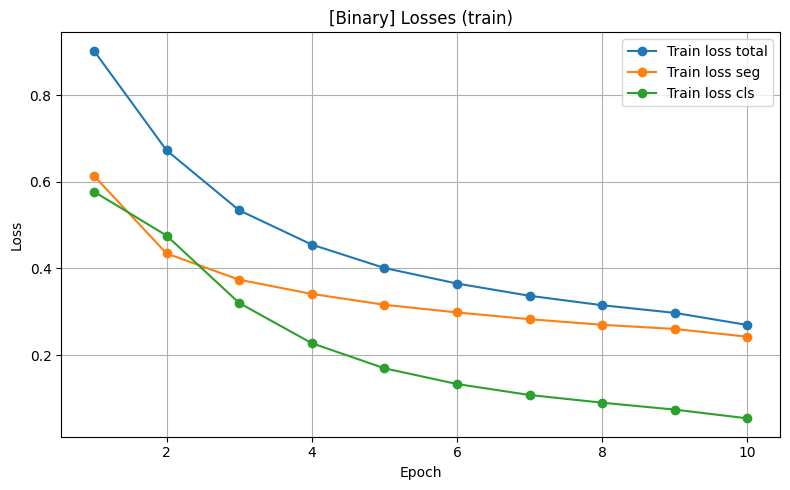

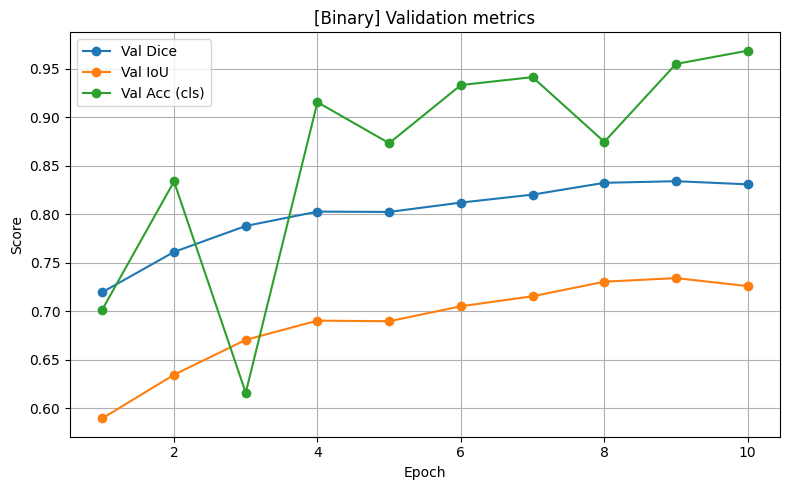

In [16]:

def plot_history_multitask(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_loss"], marker="o", label="Train loss total")
    plt.plot(epochs, history["train_seg"],  marker="o", label="Train loss seg")
    plt.plot(epochs, history["train_cls"],  marker="o", label="Train loss cls")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Losses (train)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["val_dice"], marker="o", label="Val Dice")
    plt.plot(epochs, history["val_iou"],  marker="o", label="Val IoU")
    plt.plot(epochs, history["val_acc"],  marker="o", label="Val Acc (cls)")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"{title_prefix} Validation metrics")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history_multitask(history_bin, title_prefix="[Binary]")


## 9) Expérience B — Classification fine (37 races)
On passe à `n_cls_classes=37` et le dataset fournit un label `0..36`.
Ensuite on calcule la matrice de confusion 37×37.

In [17]:
trainval_dataset = OxfordMultiTaskDataset(cfg.ROOT_DIR, split="trainval", target_size=(256,256), cls_mode = "breed")
test_dataset     = OxfordMultiTaskDataset(cfg.ROOT_DIR, split="test",     target_size=(256,256), cls_mode = "breed")

val_ratio = 0.10
n_total = len(trainval_dataset)
n_val   = int(val_ratio * n_total)
n_train = n_total - n_val

g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val], generator=g)

train_loader_37 = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
val_loader_37   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
test_loader_37  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

Dataset trainval chargé : 7349 images.
Dataset test chargé : 3669 images.


In [18]:

num_breeds = len(breeds)

model_37 = UNetMultiTask(n_channels=3, n_seg_classes=cfg.NUM_SEG_CLASSES, n_cls_classes=num_breeds).to(device)

seg_criterion = nn.CrossEntropyLoss()
cls_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_37.parameters(), lr=cfg.LR)

ckpt_37 = os.path.join(cfg.ROOT_DIR, "best_multitask_37cls.pth")

history_37 = train_multitask_with_val(
    model_37, train_loader_37, val_loader_37, device,
    seg_criterion, cls_criterion, optimizer,
    lambda_cls=cfg.LAMBDA_CLS, epochs=cfg.EPOCHS,
    num_seg_classes=cfg.NUM_SEG_CLASSES, ignore_index=cfg.IGNORE_INDEX,
    save_path=ckpt_37
)

model_37.load_state_dict(torch.load(ckpt_37, map_location=device))
dice_t, iou_t, acc_t = evaluate_multitask(model_37, test_loader_37, device,
                                         num_seg_classes=cfg.NUM_SEG_CLASSES, ignore_index=cfg.IGNORE_INDEX)
print(f"\n[Test - 37 classes] Dice={dice_t:.4f} | IoU={iou_t:.4f} | Acc_cls={acc_t:.4f}")


Epoch 01/10 | Loss=2.2340 (seg=0.6194, cls=3.2292) | Acc_train=0.1240 | Val Dice=0.7020 | Val IoU=0.5699 | Val Acc=0.1376
Epoch 02/10 | Loss=1.8116 (seg=0.4431, cls=2.7369) | Acc_train=0.2351 | Val Dice=0.7313 | Val IoU=0.6014 | Val Acc=0.2112
Epoch 03/10 | Loss=1.5890 (seg=0.3901, cls=2.3978) | Acc_train=0.3274 | Val Dice=0.7759 | Val IoU=0.6551 | Val Acc=0.2493
Epoch 04/10 | Loss=1.4236 (seg=0.3617, cls=2.1238) | Acc_train=0.3923 | Val Dice=0.7984 | Val IoU=0.6834 | Val Acc=0.3038
Epoch 05/10 | Loss=1.2468 (seg=0.3329, cls=1.8280) | Acc_train=0.4748 | Val Dice=0.7864 | Val IoU=0.6723 | Val Acc=0.3883
Epoch 06/10 | Loss=1.1051 (seg=0.3099, cls=1.5906) | Acc_train=0.5556 | Val Dice=0.8111 | Val IoU=0.7026 | Val Acc=0.3420
Epoch 07/10 | Loss=0.9825 (seg=0.2949, cls=1.3751) | Acc_train=0.6045 | Val Dice=0.7994 | Val IoU=0.6861 | Val Acc=0.5354
Epoch 08/10 | Loss=0.8766 (seg=0.2796, cls=1.1940) | Acc_train=0.6652 | Val Dice=0.8265 | Val IoU=0.7216 | Val Acc=0.5668
Epoch 09/10 | Loss=0.793

### Matrice de confusion 37×37

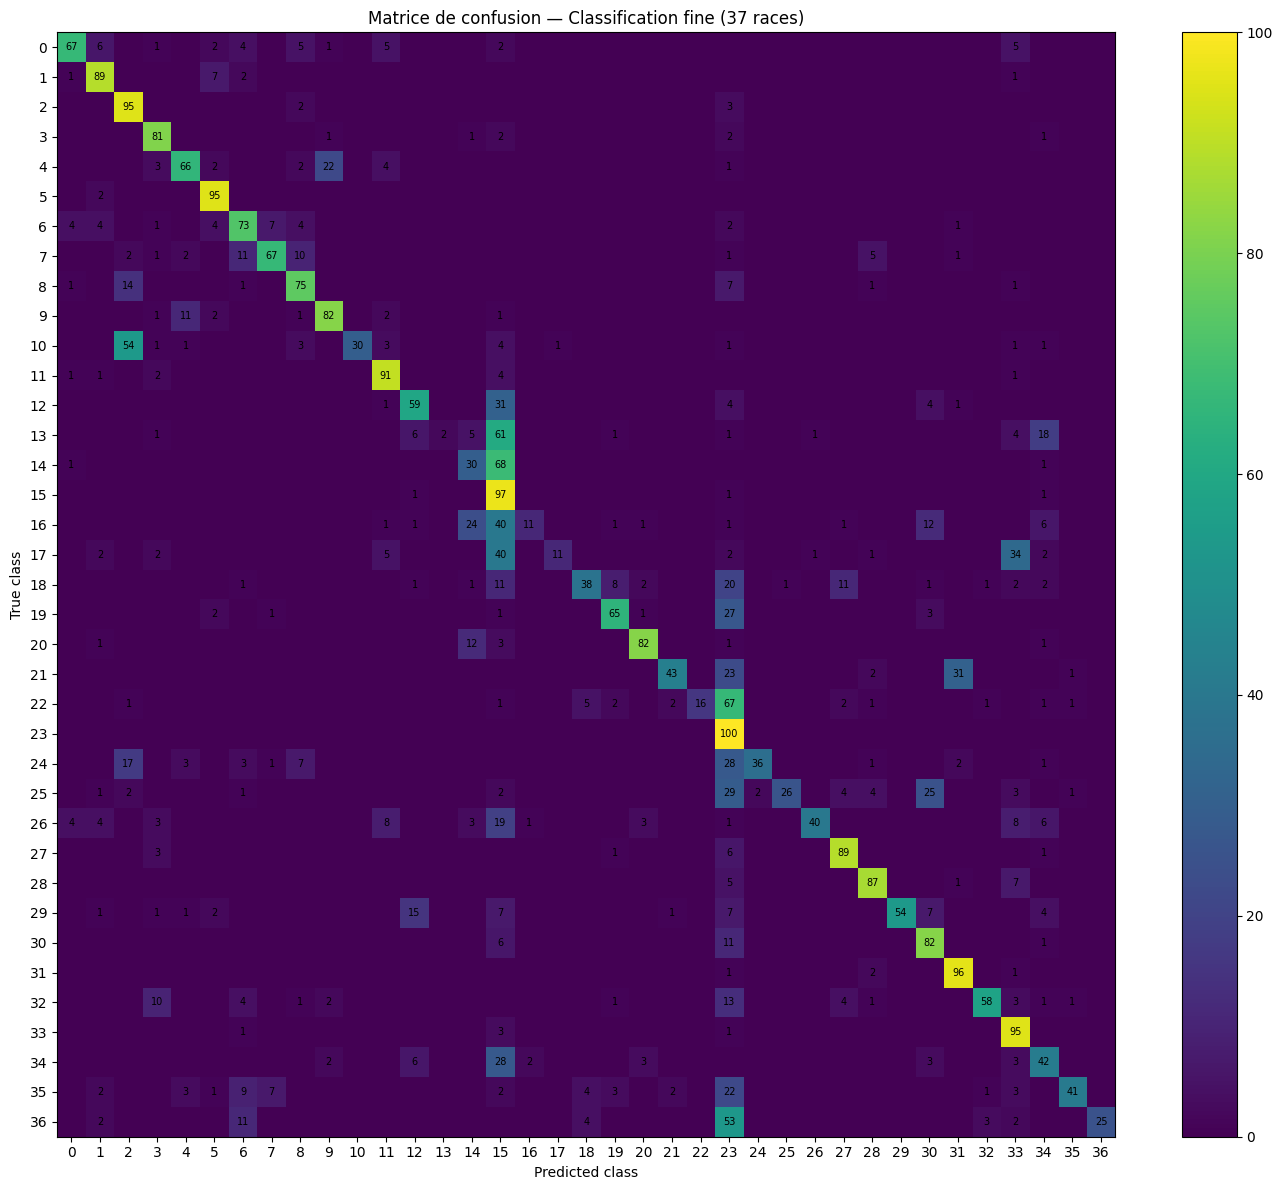

In [19]:

from sklearn.metrics import confusion_matrix

@torch.no_grad()
def confusion_multiclass(model, loader, device, num_classes: int):
    model.eval()
    y_true, y_pred = [], []
    for images, _masks, cls_labels, _names in loader:
        images = images.to(device)
        cls_labels = cls_labels.to(device)
        _seg, cls_logits = model(images)
        pred = torch.argmax(cls_logits, dim=1)
        y_true.extend(cls_labels.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    return confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

def plot_confusion_matrix_like(cm: np.ndarray, title="Confusion matrix (37 classes)"):
    plt.figure(figsize=(14, 12))
    plt.imshow(cm, aspect="auto")
    plt.colorbar()
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.title(title)

    n = cm.shape[0]
    plt.xticks(range(n), range(n))
    plt.yticks(range(n), range(n))

    for i in range(n):
        for j in range(n):
            v = cm[i, j]
            if v != 0:
                plt.text(j, i, str(v), ha="center", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()

cm37 = confusion_multiclass(model_37, test_loader_37, device, num_classes=num_breeds)
plot_confusion_matrix_like(cm37, title="Matrice de confusion — Classification fine (37 races)")


### Courbes (37 classes)
On trace les courbes pour cette expérience aussi.

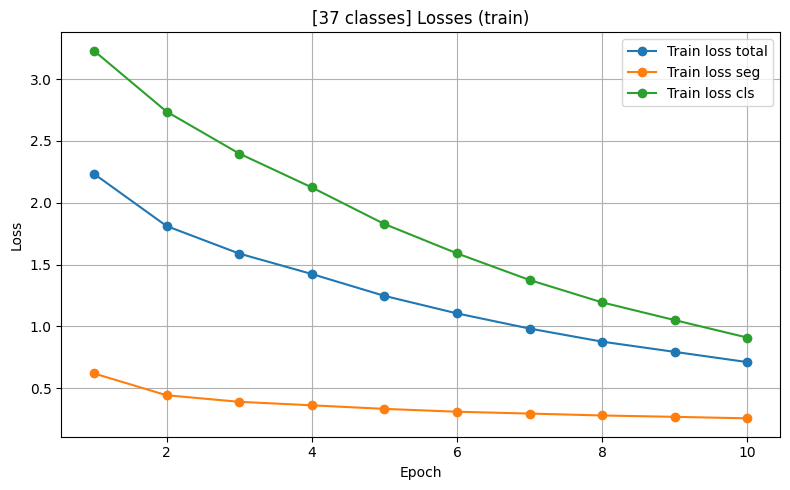

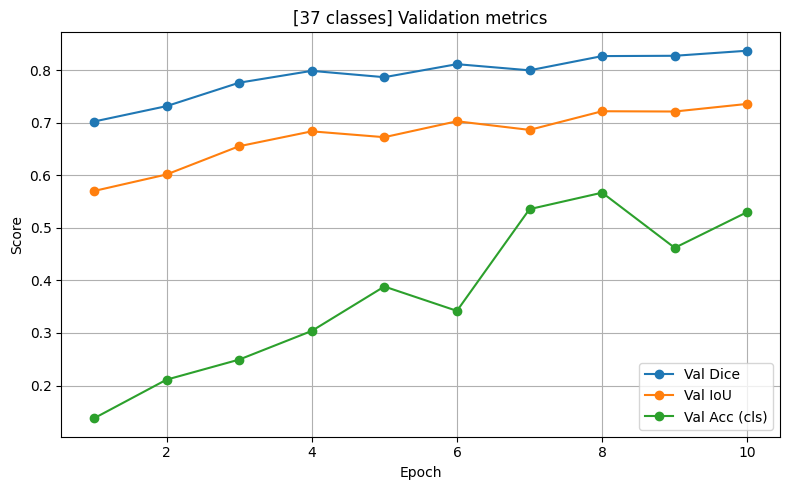

In [20]:

plot_history_multitask(history_37, title_prefix="[37 classes]")


## 10) Sauvegarder les historiques

In [21]:

hist_bin_path = os.path.join(cfg.ROOT_DIR, "history_multitask_binary.json")
hist_37_path  = os.path.join(cfg.ROOT_DIR, "history_multitask_37cls.json")

with open(hist_bin_path, "w") as f:
    json.dump(history_bin, f, indent=2)
with open(hist_37_path, "w") as f:
    json.dump(history_37, f, indent=2)

print("Saved:", hist_bin_path)
print("Saved:", hist_37_path)
print("Checkpoints:", ckpt_bin, "and", ckpt_37)


Saved: /home/el-morady/Téléchargements/HDDL_fv/history_multitask_binary.json
Saved: /home/el-morady/Téléchargements/HDDL_fv/history_multitask_37cls.json
Checkpoints: /home/el-morady/Téléchargements/HDDL_fv/best_multitask_binary.pth and /home/el-morady/Téléchargements/HDDL_fv/best_multitask_37cls.pth
